# Libraries 

In [5]:
import pandas as pd
import numpy as np
from Content_Object import *
from LFUCache import *
from LRUCache import *
from OPT import *
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.max_rows', None)

# Functions

In [51]:
def readData(path):
    print("Reading data from"+path)
    df=pd.read_csv(path)
    print(df.shape)
    display(df.head())
    return df

def colmnDiff(dfOld, dfNew):
    print("Old Feature:")
    oldClmns= list(dfOld.columns)
    print(oldClmns)
    print("New Feature:")
    diffClms= list(set(dfNew.columns).difference(set(dfOld.columns)))
    print(diffClms)
    return diffClms

def getUnique(df):
    Cols= df.columns
    print("Unique values for columns")
    for col in Cols:
        n= df[col].nunique()
        print(col, n)
        Uni= pd.unique(df[col])
        if n > 15:
            print(Uni[:5], "...", Uni[-5:])
        else:
            print(Uni)
    
def plotAll(df, col2="response_status"):
    print("How is everything related to hit\miss")
    for col in df.columns:
        df.groupby([col, col2]).size().unstack().nlargest(25,'tcp_hit').plot(kind='bar', stacked=True)
        plt.show()
            
def get_HR(df, algo="response"):
    OHR= df[df[algo+"_status"]=="tcp_hit"].shape[0]/df.shape[0] *100
    BHR= df[df[algo+"_status"]=="tcp_hit"]["byte_sent"].sum()/df["byte_sent"].sum() *100
    print(algo+" OHR: ",OHR," BHR: ",BHR, "#requests", df.shape[0])
    
def encodeCol(df, col):
    dfnew=df
    dfnew[col] = df[col].astype('category').cat.codes
    return dfnew

def sortTime(dfpass):
    df=dfpass.copy()
    df['time_received'] = pd.to_datetime(df['time_received'])
    df = df.sort_values('time_received')
    df = df.reset_index(drop=True)
    return df

def getIntialCache(df, object_id_set):
    print("#requests:", df.shape[0])
    df1 = df.drop_duplicates(subset=object_id_set)
    df_hit = df1[df1.response_status == 'tcp_hit']
    df_hit = df_hit.reset_index(drop=True)
    df_hit['object_id'] = df_hit.index
    df_initial = df_hit[['object_id'] + object_id_set]
    print("#cached requests",df_initial.shape[0])
    return df_initial

def filterHost(df, host):
    dfNew=df[df['host_id'] == host]
    dfNew = dfNew.reset_index(drop=True)
    return dfNew

def addObjectId(dfpass, df_initial, object_id_set):
    df=dfpass.copy()
    content = Content_Object(df_initial, object_id_set)
    object_id = [None] * df.shape[0]
    df_object_id= df.loc[:,object_id_set]

    for index in range(df.shape[0]):
        object_id[index]= int(content.getid(tuple(df_object_id.loc[index,:].values)))
        if index%100000==0:
            print(index)
    df.loc[:,"object_id"]= object_id
    print("#/% of distinct objects:", max(object_id), max(object_id)/df.shape[0]*100)
    return df

def perpareForAlgo(df):
    df_algo= df[['object_id','byte_sent']]
    df_algo['time']= df_algo.index
    df_algo1= df_algo[['time', 'object_id', 'byte_sent']]
    display(df_algo1.head())
    return df_algo1

def getHitRatesAlgo(item):
    N= np.sum(item["segment_object_req"])
    OHR= (N- np.sum(item["segment_object_miss"])) / N *100
    N= np.sum(item["segment_byte_req"])
    BHR= (N- np.sum(item["segment_byte_miss"])) / N *100
    return OHR, BHR

def pltDict(D, name):
    figure(figsize=(12,4))
    br= plt.bar(range(len(D)), [round(num, 2) for num in list(D.values())] , align='center')
    plt.xticks(range(len(D)), list(D.keys()), rotation='vertical')
    plt.ylim([min(D.values())-2, max(D.values())+10])
    plt.title(name)
    plt.bar_label(br)
    plt.show()

def pltTraffic(dfpass):
    df=dfpass.copy()
    print("Time Range:", min(df['time_received']), max(df['time_received']), "#requests:", df.shape[0])
    df= sortTime(df)
    ax = df.groupby(['time_received', 'host_id']).size().unstack().plot(figsize=(14,4))
    ax.set_ylabel("#requests/s")
    
def pltnunique(dfpass):
    df=dfpass.copy()
    df.nunique().sort_values(ascending=False).plot(kind='bar', figsize=(14,4), logy=True, rot=45)
    plt.ylabel("#distinct")
    plt.show()

def getMaxUnique(df, col1, col2):
    print(str(col1), "has max:", max(df.groupby(col1)[col2].nunique()), str(col2))

def deleteZeroByte(dfpass):  
    df=dfpass.copy()
    before=df.shape[0]
    df['byte_sent']= df['byte_sent'].astype(int)
    df=df[df['byte_sent'] != 0]
    print("#rows deleted:", before- df.shape[0])
    return df

def getNumUnique(df, cols):
    n=df.groupby(cols).size().shape[0]
    print(df.shape[0], n, (1-n/df.shape[0])*100)

# Exploratory Data Analysis

## Read data

In [7]:
dfVoD=readData('../../Data/VoD_DSLab01.csv')

Reading data from../../Data/VoD_DSLab01.csv
(1577063, 22)


device_type  live_tv_id  request_url request_method  \
0          0.0         NaN     73218596       HTTP/1.1   
1          0.0         NaN     74962598       HTTP/1.1   
2          0.0         NaN     74687485       HTTP/1.1   
3          0.0         NaN     73908576       HTTP/1.1   
4          0.0         NaN     74687475       HTTP/1.1   

               time_received  user_loc     byte_sent  vod_encoding  \
0  2021-11-14 06:00:14+00:00         0   1542.095238          10.0   
1  2021-11-14 06:19:57+00:00      1816  70985.984127        1659.0   
2  2021-11-14 06:21:14+00:00       944  65501.857143        2673.0   
3  2021-11-14 06:21:18+00:00         0  73345.412698        2580.0   
4  2021-11-14 06:22:01+00:00       944   1579.349206        2673.0   

   time_to_serve content_type  ...                    cachecontrol  method  \
0       0.000274   video/mpeg  ...  Cache-Control:max-age=31536000     GET   
1       0.430289    video/mp4  ...  Cache-Control:max-age=31536000     GET   
2       2.474124    video/mp4  ...  Cache-Control:max-age=31536000     GET   
3       0.380959    video/mp4  ...  Cache-Control:max-age=31536000     GET   
4       0.000244   video/mpeg  ...  Cache-Control:max-age=31536000     GET   

  response_status user_id host_id  vod_id  devicebrand  statuscode  \
0         tcp_hit     NaN       4  2751.0          NaN         206   
1         tcp_hit     NaN       4  3031.0          NaN         206   
2         tcp_hit     NaN       4  2978.0          NaN         206   
3         tcp_hit     NaN       4  2868.0          NaN         206   
4         tcp_hit     NaN       4  2978.0          NaN         206   

   user_agent  request_header  
0        12.0             NaN  
1        12.0             NaN  
2        12.0             NaN  
3        12.0             NaN  
4        12.0             NaN  

[5 rows x 22 columns]

In [8]:
dfVoD= dfVoD.fillna("-1")

## Traffic Analysis

In [9]:
pltTraffic(dfVoD)

Time Range: 2021-11-13 06:59:04+00:00 2021-11-16 00:00:00+00:00 #requests: 1577063


## dfs per host

In [10]:
dfDict= {}
dfDict['4']=filterHost(dfVoD, 4)
dfDict['12']=filterHost(dfVoD, 12)

## sorting by time

In [12]:
for key in dfDict:
    dfDict[key]= sortTime(dfDict[key])

## unique values

In [13]:
for key in dfDict:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    getUnique(dfDict[key])

4 ----- 715858 ---------------------------------------------------------------------------------
Unique values for columns
device_type 16
[0.0 196.0 1.0 8.0 94.0] ... [45.0 350.0 36.0 39.0 32.0]
live_tv_id 1
['-1']
request_url 4865
[73178728 73178738 73179594     2463     2457] ... [79549244 79549237 23882917 23882914 23882907]
request_method 1
['HTTP/1.1']
time_received 150530
<DatetimeArray>
['2021-11-13 06:59:04+00:00', '2021-11-13 06:59:05+00:00',
 '2021-11-13 06:59:14+00:00', '2021-11-13 06:59:15+00:00',
 '2021-11-13 06:59:16+00:00']
Length: 5, dtype: datetime64[ns, UTC] ... <DatetimeArray>
['2021-11-15 23:59:56+00:00', '2021-11-15 23:59:57+00:00',
 '2021-11-15 23:59:58+00:00', '2021-11-15 23:59:59+00:00',
 '2021-11-16 00:00:00+00:00']
Length: 5, dtype: datetime64[ns, UTC]
user_loc 499
[   0 2679  580    4 2395] ... [2987 4825 3341 4313 4244]
byte_sent 72207
[5.44375238e+04 1.29579365e+03 1.54692063e+03 1.84126984e+00
 1.04285714e+01] ... [70946.28571429 62809.3015873  71576.65079

### Based on the unique values, we are curious about the following:
- we will delete not useful colmns- ex: with only one value
- byte_sent is low and double value
- statuscode records for 40*, 50*
- maxage vs cachecontrol, and study no cache
- relations between features

## clear

In [14]:
for key in dfDict:
    dfDict[key].drop(['host_id','request_method','method','user_id','user_loc','device_type','session_id','devicebrand','user_agent','request_header'], axis=1, inplace=True)

## statuscode

In [15]:
for key in dfDict:
    print(key, "--------------------------------------------------------------------------------------")
    print(dfDict[key]['statuscode'].value_counts())

4 --------------------------------------------------------------------------------------
206    714997
200       850
403         9
503         2
Name: statuscode, dtype: int64
12 --------------------------------------------------------------------------------------
200    861196
403         8
503         1
Name: statuscode, dtype: int64


In [16]:
# filter and get some values
error_codes= [400,412,404,503,403]
# unique values
for key in dfDict:
    df=dfDict[key]
    print(key, "--------------------------------------------------------------------------------------")
    display(df[df['statuscode'].isin(error_codes)].head())

4 --------------------------------------------------------------------------------------


live_tv_id  request_url             time_received  byte_sent  \
104311         -1          935 2021-11-13 20:18:39+00:00  19.571429   
179541         -1          935 2021-11-13 23:37:59+00:00  19.571429   
208079         -1          935 2021-11-14 02:40:52+00:00  19.571429   
220044         -1          935 2021-11-14 06:53:32+00:00  19.571429   
287629         -1          935 2021-11-14 19:32:10+00:00  19.571429   

       vod_encoding  time_to_serve content_type  maxage  \
104311           -1       0.014446    text/html  7200.0   
179541           -1       0.015377    text/html  7200.0   
208079           -1       0.016351    text/html  7200.0   
220044           -1       0.014980    text/html  7200.0   
287629           -1       0.015373    text/html  7200.0   

                      cachecontrol response_status vod_id  statuscode  
104311  Cache-Control:max-age=7200        tcp_miss     -1         403  
179541  Cache-Control:max-age=7200        tcp_miss     -1         403  
208079  Cache-Control:max-age=7200        tcp_miss     -1         403  
220044  Cache-Control:max-age=7200        tcp_miss     -1         403  
287629  Cache-Control:max-age=7200        tcp_miss     -1         403

12 --------------------------------------------------------------------------------------


live_tv_id  request_url             time_received  byte_sent  \
8505           -1          935 2021-11-13 08:46:49+00:00  19.571429   
16127          -1          935 2021-11-13 10:36:37+00:00  19.571429   
164859         -1          935 2021-11-13 23:22:38+00:00  19.571429   
213224         -1          935 2021-11-14 03:13:22+00:00  19.571429   
250804         -1          935 2021-11-14 10:09:52+00:00  19.571429   

       vod_encoding  time_to_serve content_type  maxage  \
8505             -1       0.020189    text/html  7200.0   
16127            -1       0.021090    text/html  7200.0   
164859           -1       0.021120    text/html  7200.0   
213224           -1       0.019443    text/html  7200.0   
250804           -1       0.025590    text/html  7200.0   

                      cachecontrol response_status vod_id  statuscode  
8505    Cache-Control:max-age=7200        tcp_miss     -1         403  
16127   Cache-Control:max-age=7200        tcp_miss     -1         403  
164859  Cache-Control:max-age=7200        tcp_miss     -1         403  
213224  Cache-Control:max-age=7200        tcp_miss     -1         403  
250804  Cache-Control:max-age=7200        tcp_miss     -1         403

Questions:
- do error requests get cached? let's see hit miss
https://support.huaweicloud.com/intl/en-us/cdn_faq/cdn_faq_0136.html

In [17]:
for key in dfDict:
    df=dfDict[key]
    print(key, "--------------------------------------------------------------------------------------")
    display(df[df['statuscode'].isin(error_codes)]['response_status'].value_counts())

4 --------------------------------------------------------------------------------------


tcp_miss    11
Name: response_status, dtype: int64

12 --------------------------------------------------------------------------------------


tcp_miss    9
Name: response_status, dtype: int64

In [18]:
# as they all miss, let's delete these rows
for key in dfDict:
    df=dfDict[key]
    dfDict[key]=df[~df['statuscode'].isin(error_codes)]

In [19]:
# check non left
for key in dfDict:
    print(key, "--------------------------------------------------------------------------------------")
    print(dfDict[key]['statuscode'].value_counts())

4 --------------------------------------------------------------------------------------
206    714997
200       850
Name: statuscode, dtype: int64
12 --------------------------------------------------------------------------------------
200    861196
Name: statuscode, dtype: int64


## maxage vs cachecontrol, and study no cache

In [20]:
for key in dfDict:
    print(key, "--------------------------------------------------------------------------------------")
    print(dfDict[key]['cachecontrol'].value_counts())
    print(dfDict[key]['maxage'].value_counts())

4 --------------------------------------------------------------------------------------
Cache-Control:max-age=31536000                                704541
Cache-Control:private, no-cache, no-store, must-revalidate      6884
Cache-Control:max-age=7200                                      4422
Name: cachecontrol, dtype: int64
31536000.0    704541
-1              6884
7200.0          4422
Name: maxage, dtype: int64
12 --------------------------------------------------------------------------------------
Cache-Control:max-age=31536000                                857885
Cache-Control:private, no-cache, no-store, must-revalidate      2496
Cache-Control:max-age=7200                                       759
Cache-Control:max-age=31536000,max-age=7200                       56
Name: cachecontrol, dtype: int64
31536000.0    857941
-1              2496
7200.0           759
Name: maxage, dtype: int64


#### They seems exactly the same with -1 means no cache, so we will remove Cache-Control, and work with max-age 

In [21]:
# drop cachecontrol
for key in dfDict:
    dfDict[key].drop(['cachecontrol'], inplace=True, axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
# check if no cache is considered -> miss
for key in dfDict:
    df=dfDict[key]
    print(key, "--------------------------------------------------------------------------------------")
    display(df[df['maxage']=='-1']['response_status'].value_counts())

4 --------------------------------------------------------------------------------------


tcp_miss    6884
Name: response_status, dtype: int64

12 --------------------------------------------------------------------------------------


tcp_miss    2496
Name: response_status, dtype: int64

In [23]:
# as they all miss, let's delete these rows
for key in dfDict:
    df=dfDict[key]
    dfDict[key]=df[df['maxage']!='-1']

In [24]:
# check non left
for key in dfDict:
    print(key, "--------------------------------------------------------------------------------------")
    print(dfDict[key]['maxage'].value_counts())

4 --------------------------------------------------------------------------------------
31536000.0    704541
7200.0          4422
Name: maxage, dtype: int64
12 --------------------------------------------------------------------------------------
31536000.0    857941
7200.0           759
Name: maxage, dtype: int64


## unique values

In [25]:
for key in dfDict:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    getUnique(dfDict[key])

4 ----- 708963 ---------------------------------------------------------------------------------
Unique values for columns
live_tv_id 1
['-1']
request_url 3664
[73178728 73178738     2463     2457     2461] ... [79546207 79549240 79549244 23882917 23882914]
time_received 150387
<DatetimeArray>
['2021-11-13 06:59:04+00:00', '2021-11-13 06:59:05+00:00',
 '2021-11-13 06:59:14+00:00', '2021-11-13 06:59:15+00:00',
 '2021-11-13 06:59:16+00:00']
Length: 5, dtype: datetime64[ns, UTC] ... <DatetimeArray>
['2021-11-15 23:59:56+00:00', '2021-11-15 23:59:57+00:00',
 '2021-11-15 23:59:58+00:00', '2021-11-15 23:59:59+00:00',
 '2021-11-16 00:00:00+00:00']
Length: 5, dtype: datetime64[ns, UTC]
byte_sent 71546
[5.44375238e+04 1.29579365e+03 1.54692063e+03 1.84126984e+00
 1.04285714e+01] ... [70946.28571429 62809.3015873  71576.65079365 68610.03174603
 69510.74603175]
vod_encoding 1199
[2494.0 0.0 '-1' 1.0 1363.0] ... [877.0 2014.0 3068.0 3069.0 879.0]
time_to_serve 270192
[0.001705 0.000262 0.011458 0.

## Check number of distinct values for each feature

4


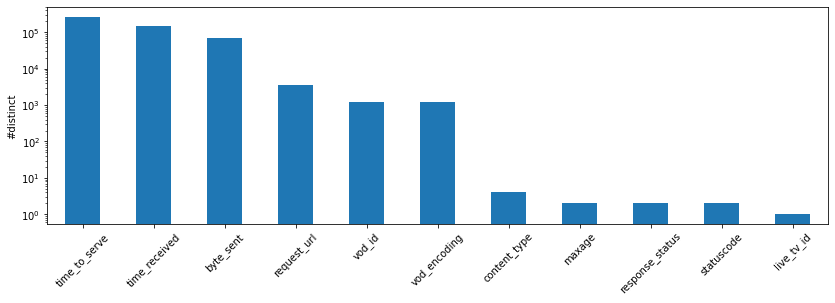

12


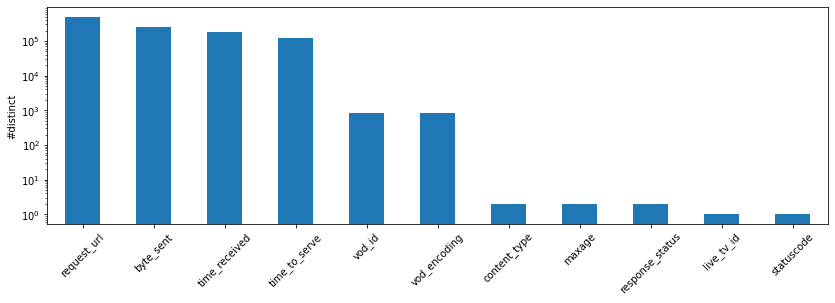

In [26]:
for key in dfDict:
    print(key)
    pltnunique(dfDict[key])

## Relation between features

### 'content_type', 'maxage' relation

In [27]:
for key in dfDict:
    print(key)
    dfDict[key].groupby(['content_type', 'maxage']).size().unstack().plot(kind='bar', stacked=True)
    plt.show()

4


12


### 'content_type', 'statuscode' relation

In [28]:
for key in dfDict:
    print(key)
    dfDict[key].groupby(['content_type', 'statuscode']).size().unstack().plot(kind='bar', stacked=True)
    plt.show()

4


12


### df new

In [29]:
for key in ['4','12']:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    getMaxUnique(dfDict[key], 'request_url', 'byte_sent')
    getMaxUnique(dfDict[key], 'request_url', 'vod_id')
    getMaxUnique(dfDict[key], 'request_url', 'content_type')

4 ----- 708963 ---------------------------------------------------------------------------------
request_url has max: 1199 byte_sent
request_url has max: 1 vod_id
request_url has max: 1 content_type
12 ----- 858700 ---------------------------------------------------------------------------------
request_url has max: 125 byte_sent
request_url has max: 1 vod_id
request_url has max: 1 content_type


### request_url , byte_sent

In [30]:
for key in ['4','12']:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    df=dfDict[key]
    display(np.unique(df.groupby('request_url')['byte_sent'].nunique(), return_counts=True))

4 ----- 708963 ---------------------------------------------------------------------------------


(array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
          34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
          45,   46,   47,   48,   49,   50,   51,   53,   54,   55,   57,
          58,   59,   60,   61,   62,   64,   67,   69,   74,   77,   78,
          82,   83,   88,   89,   93,  100,  110,  112,  114,  118,  121,
         126,  127,  132,  133,  134,  135,  136,  137,  138,  139,  140,
         141,  142,  143,  144,  145,  146,  147,  148,  149,  150,  151,
         152,  153,  154,  155,  156,  160,  162,  163,  165,  166,  169,
         170,  171,  173,  179,  180,  181,  188,  200,  216,  220,  226,
         233,  267,  271,  287,  288,  351,  420,  428,  429,  430,  431,
         432,  434,  436,  437,  438,  440,  441,  442,  443,  446,  448,
         449,  452,  453,  454,  455, 

12 ----- 858700 ---------------------------------------------------------------------------------


(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  17,  18,  19,  37, 125]),
 array([502742,   1376,     94,     33,     13,     11,      9,      3,
             2,      3,      1,      1,      2,      1,      1,      1,
             1,      2,      1,      1]))

### 'request_url', 'byte_sent' relation

In [31]:
def getN_connection(dfpass, col, MinOccur=-1):
    print(col)
    df=dfpass.copy()
    if MinOccur==-1:
        MinOccur= max(df.groupby('request_url')[col].nunique())
    dfgrp=pd.DataFrame({'count' :df.groupby(['request_url',col]).size()}).reset_index()
    dfgrp['Occur'] = dfgrp.groupby('request_url')[col].transform('size')
    dfmax= dfgrp[dfgrp['Occur']>=max(df.groupby('request_url')[col].nunique())]
    df2= dfgrp[dfgrp['Occur']>=MinOccur]
    display(dfmax.head(20))
    urlMax=dfmax['request_url'].unique()
    urls=df2['request_url'].unique()
    df[df['request_url']==urlMax[0]].hist("byte_sent", bins=50)
    plt.show()
    return df[df['request_url'].isin(urls)].sort_values('time_received')

4 ----- 708963 ---------------------------------------------------------------------------------
byte_sent


request_url    byte_sent  count  Occur
89580     74647235    27.523810     82   1199
89581     74647235   209.269841     16   1199
89582     74647235  1317.730159      3   1199
89583     74647235  1363.444444      3   1199
89584     74647235  1363.460317      1   1199
89585     74647235  6506.301587      1   1199
89586     74647235  6529.158730      1   1199
89587     74647235  6689.158730      1   1199
89588     74647235  6734.873016      1   1199
89589     74647235  6803.444444      1   1199
89590     74647235  6826.301587      4   1199
89591     74647235  6872.015873      1   1199
89592     74647235  6940.492063      1   1199
89593     74647235  6940.587302     43   1199
89594     74647235  6940.603175      1   1199
89595     74647235  6963.444444     12   1199
89596     74647235  6963.460317      1   1199
89597     74647235  7054.777778      1   1199
89598     74647235  7054.873016     11   1199
89599     74647235  7054.888889      1   1199

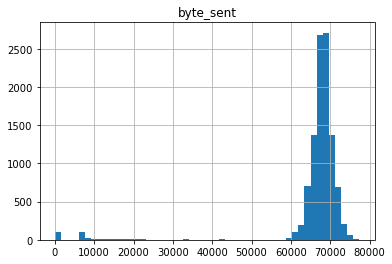

Empty DataFrame
Columns: [live_tv_id, request_url, time_received, byte_sent, vod_encoding, time_to_serve, content_type, maxage, response_status, vod_id, statuscode]
Index: []

12 ----- 858700 ---------------------------------------------------------------------------------
byte_sent


request_url    byte_sent  count  Occur
196650     54274620  3460.031746      1    125
196651     54274620  3604.793651      1    125
196652     54274620  3696.222222      1    125
196653     54274620  3833.349206      1    125
196654     54274620  3970.507937      2    125
196655     54274620  3993.365079      1    125
196656     54274620  4039.079365      1    125
196657     54274620  4130.507937      1    125
196658     54274620  4215.587302      1    125
196659     54274620  4244.793651      1    125
196660     54274620  4282.253968      1    125
196661     54274620  4290.492063      1    125
196662     54274620  4519.079365      1    125
196663     54274620  4587.650794      1    125
196664     54274620  4633.365079      1    125
196665     54274620  4701.936508      1    125
196666     54274620  4837.809524      1    125
196667     54274620  4861.936508      1    125
196668     54274620  4976.222222      1    125
196669     54274620  5021.936508      1    125

live_tv_id  request_url             time_received     byte_sent  \
838552         -1     74484359 2021-11-15 23:15:11+00:00  45232.793651   
838648         -1     54274620 2021-11-15 23:15:24+00:00  38814.142857   
838647         -1     54274620 2021-11-15 23:15:24+00:00   8953.349206   
838663         -1     54274744 2021-11-15 23:15:26+00:00  40989.682540   
838732         -1     54274620 2021-11-15 23:15:33+00:00   5936.206349   
838734         -1     54274620 2021-11-15 23:15:33+00:00  38814.142857   
838758         -1     54274744 2021-11-15 23:15:35+00:00  40989.682540   
838818         -1     55346825 2021-11-15 23:15:41+00:00  11376.206349   
838829         -1     55346825 2021-11-15 23:15:41+00:00  32977.365079   
838830         -1     74484473 2021-11-15 23:15:42+00:00  42899.460317   
838893         -1     54275699 2021-11-15 23:15:46+00:00  41942.174603   
838916         -1     54275813 2021-11-15 23:15:48+00:00  34805.349206   
838956         -1     55348083 2021-11-15 23:15:52+00:00  28884.777778   
838967         -1     54275699 2021-11-15 23:15:54+00:00  41942.174603   
838972         -1     55350544 2021-11-15 23:15:54+00:00  27239.063492   
838985         -1     54280350 2021-11-15 23:15:55+00:00  31316.476190   
838991         -1     54275813 2021-11-15 23:15:56+00:00  34805.349206   
838995         -1     54280425 2021-11-15 23:15:56+00:00  37122.126984   
839026         -1     55358831 2021-11-15 23:15:59+00:00  30690.492063   
839030         -1     55360248 2021-11-15 23:15:59+00:00  32656.206349   
839036         -1     55361608 2021-11-15 23:15:59+00:00  32884.777778   
839038         -1     55365818 2021-11-15 23:16:00+00:00  38827.634921   
839040         -1     55363026 2021-11-15 23:16:00+00:00  36130.492063   
839048         -1     55364459 2021-11-15 23:16:00+00:00  30553.349206   
839058         -1     55367083 2021-11-15 23:16:01+00:00  30256.206349   
839059         -1     55368483 2021-11-15 23:16:01+00:00  14923.555556   
839081         -1     55371147 2021-11-15 23:16:02+00:00  31787.634921   
839084         -1     55375491 2021-11-15 23:16:03+00:00  29570.492063   
839096         -1     54280350 2021-11-15 23:16:03+00:00  31316.476190   
839106         -1     57355002 2021-11-15 23:16:04+00:00  32633.349206   
839103         -1     57353706 2021-11-15 23:16:04+00:00  35787.634921   
839117         -1     54280425 2021-11-15 23:16:05+00:00  37122.126984   
839138         -1     54280963 2021-11-15 23:16:07+00:00  42621.000000   
839158         -1     74484483 2021-11-15 23:16:10+00:00  37323.301587   
839177         -1     54281133 2021-11-15 23:16:11+00:00  42086.428571   
839271         -1     54280963 2021-11-15 23:16:15+00:00  42621.000000   
839340         -1     54281133 2021-11-15 23:16:19+00:00  42086.428571   
840192         -1     74484548 2021-11-15 23:17:42+00:00  36942.285714   
840274         -1     74485123 2021-11-15 23:17:52+00:00  37508.603175   
840350         -1     74485113 2021-11-15 23:18:03+00:00  32731.460317   
840410         -1     74484809 2021-11-15 23:18:12+00:00  38090.968254   
840436         -1      2878669 2021-11-15 23:18:17+00:00  32962.825397   
840439         -1      2878669 2021-11-15 23:18:17+00:00   6347.634921   
840533         -1      2879103 2021-11-15 23:18:27+00:00  32793.158730   
840693         -1     74484825 2021-11-15 23:18:41+00:00  31269.603175   
840868         -1      2886810 2021-11-15 23:19:03+00:00  21684.777778   
841072         -1      2902993 2021-11-15 23:19:26+00:00  24701.920635   
841137         -1      2909068 2021-11-15 23:19:30+00:00  21250.492063   
841154         -1     14073701 2021-11-15 23:19:31+00:00  12682.650794   
841278         -1      2916421 2021-11-15 23:19:44+00:00  20633.349206   
841283         -1      2921548 2021-11-15 23:19:45+00:00  21090.492063   
841287         -1      2918752 2021-11-15 23:19:45+00:00  16359.063492   
841294         -1      2924260 2021-11-15 23:19:45+00:00  17730.492063   
841323     

In [33]:
dfNbyte= {}
dfPerc={}
for key in ['4','12']:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    dfNbyte[key]= getN_connection(dfDict[key], 'byte_sent', 2)
    dfPerc[key]= np.round(dfNbyte[key].shape[0]/dfDict[key].shape[0] *100,2)
    display(dfNbyte[key][dfNbyte[key]['statuscode']==200].tail(100))

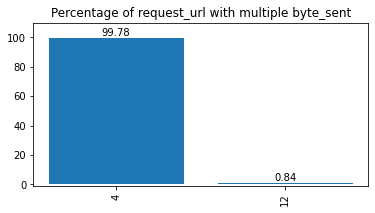

In [34]:
pltDict(dfPerc, "Percentage of request_url with multiple byte_sent")

In [35]:
for key in ['4','12']:
    print(key, "-----", dfDict[key].shape[0] ,"---------------------------------------------------------------------------------")
    print(dfNbyte[key].groupby(['content_type', 'statuscode', 'maxage', 'response_status']).size())

4 ----- 708963 ---------------------------------------------------------------------------------
content_type  statuscode  maxage      response_status
image/png     206         7200.0      tcp_hit              4329
                                      tcp_miss               93
video/mp4     206         31536000.0  tcp_hit            219471
                                      tcp_miss           137023
video/mpeg    206         31536000.0  tcp_hit            205939
                                      tcp_miss           140568
dtype: int64
12 ----- 858700 ---------------------------------------------------------------------------------
content_type  statuscode  maxage      response_status
video/mp4     200         31536000.0  tcp_hit            3869
                                      tcp_miss           3363
dtype: int64


https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Range 

https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Content-Range

https://ottverse.com/structure-of-an-mpeg-dash-mpd/

https://en.wikipedia.org/wiki/M3U

## check delay

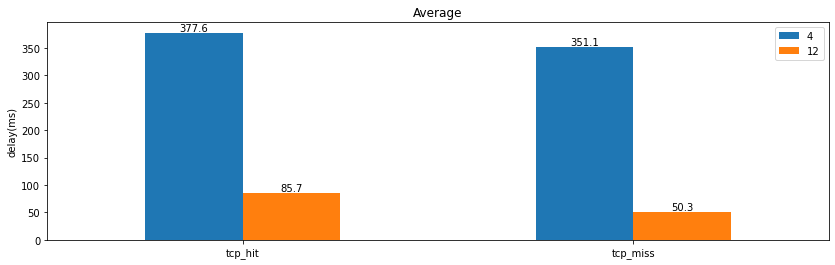

In [36]:
# mean()
dfBar=pd.DataFrame(index=['tcp_hit', 'tcp_miss'])
for key in dfDict:
    dfBar[key]= dfDict[key].groupby(['response_status'])['time_to_serve'].mean().values
ax= dfBar.multiply(1000).plot.bar(figsize=(14,4), ylabel='delay(ms)',rot=0, title='Average')
for container in ax.containers:
    ax.bar_label(container, fmt='%0.1f')

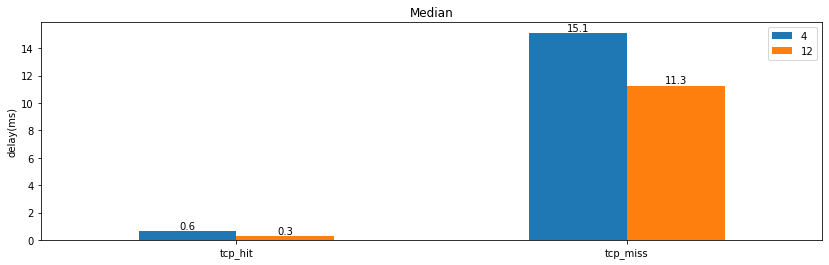

In [37]:
#median()
dfBar=pd.DataFrame(index=['tcp_hit', 'tcp_miss'])
for key in dfDict:
    dfBar[key]= dfDict[key].groupby(['response_status'])['time_to_serve'].median().values
ax= dfBar.multiply(1000).plot.bar(figsize=(14,4), ylabel='delay(ms)',rot=0, title='Median')
for container in ax.containers:
    ax.bar_label(container, fmt='%0.1f')

## Check features connection with hit/miss

In [38]:
for key in dfDict:
    print(key)
    get_HR(dfDict[key])

4
response OHR:  60.76480719022008  BHR:  61.639002910418704 #requests 708963
12
response OHR:  23.373238616513333  BHR:  22.8856633050366 #requests 858700


4
How is everything related to hit\miss


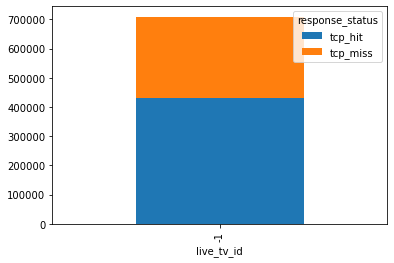

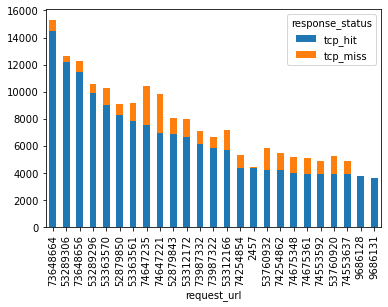

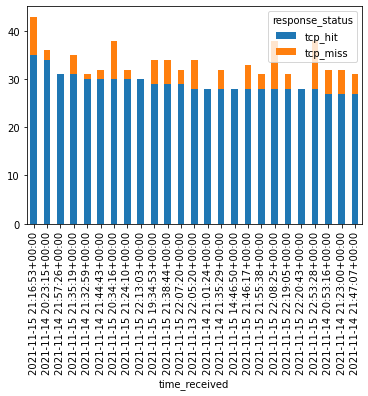

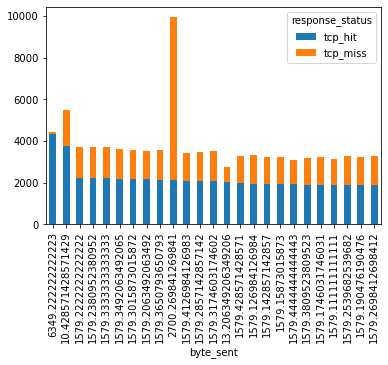

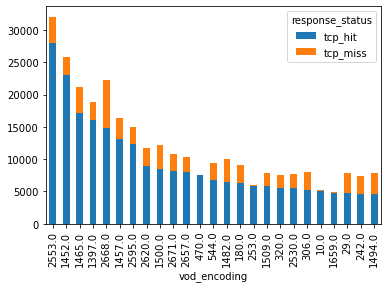

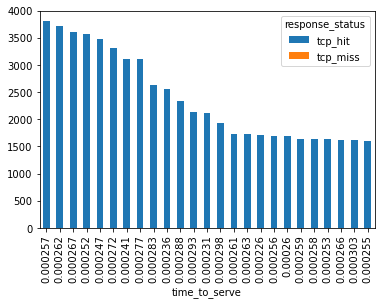

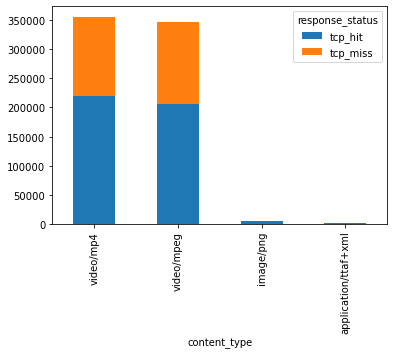

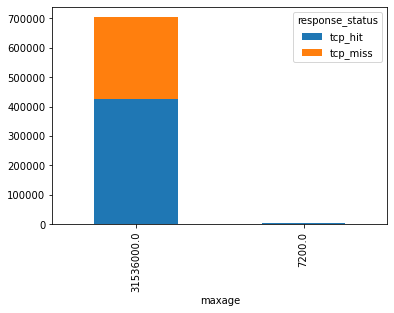

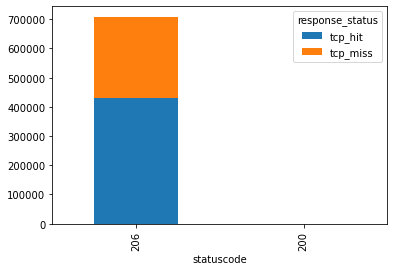

12
How is everything related to hit\miss


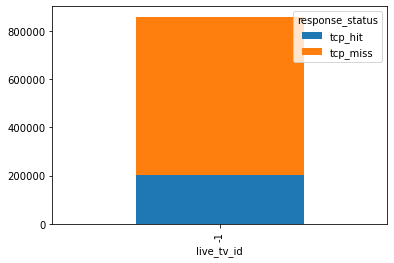

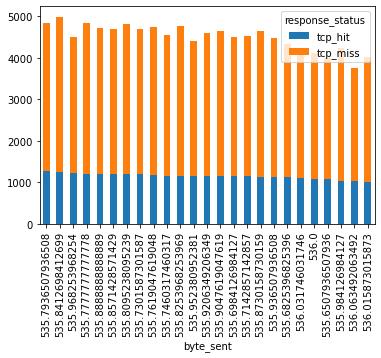

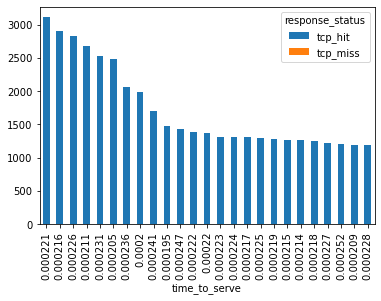

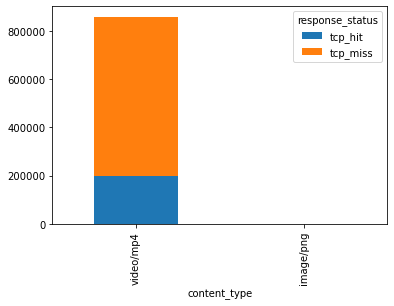

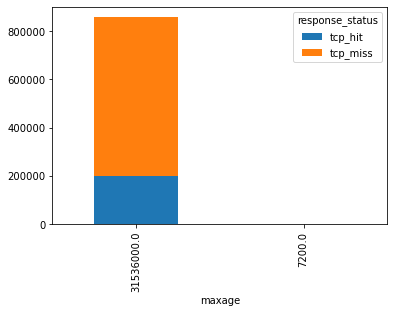

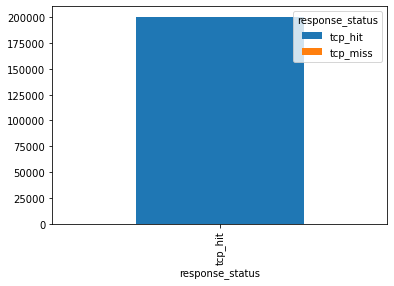

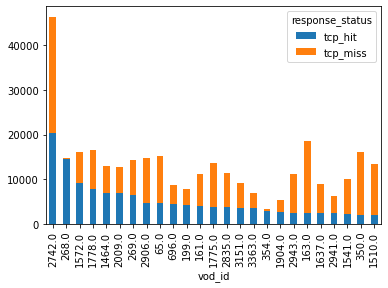

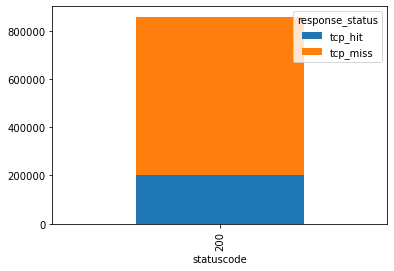

In [39]:
for key in dfDict:
    print(key)
    plotAll(dfDict[key])

We notice in new data that:
- most of the hits are when live-tv-id is nan- strange behavior
- new data has very few live-tv-id (7), not like old data
- no need to deeply preprocess content type, just encode it
- max age and Cache-Control:max-age seems similar, need to check
- What to do for hosts, they have different hit/miss behaviour
- max age null means don't cache (always miss)
- 206 Partial Content

## request size

4
12


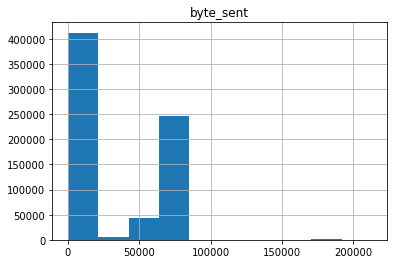

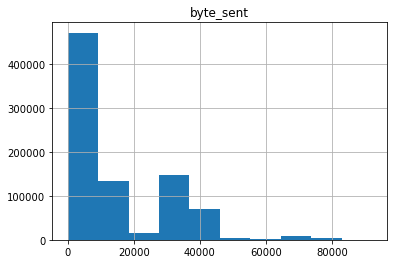

In [40]:
for key in dfDict:
    print(key)
    dfDict[key].hist("byte_sent")

# Preparation and preprocessing

## content_type

In [41]:
for key in dfDict:
    dfDict[key]= encodeCol(dfDict[key], 'content_type')

# Caching

In [44]:
object_id_setM1= ['byte_sent', 'request_url']

In [45]:
for key in dfDict:
    print(key)
    getNumUnique(dfDict[key], object_id_setM1)
    get_HR(dfDict[key])


4
708963 109338 84.57775652608105
response OHR:  60.76480719022008  BHR:  61.639002910418704 #requests 708963
12
858700 506487 41.01700244555724
response OHR:  23.373238616513333  BHR:  22.8856633050366 #requests 858700


## Intial cache +  add object id + prepare for algo + export df

In [17]:
# method2
for key in dfDict2:
    print("host: ", key)
    dfIntial= getIntialCache(dfDict[key], object_id_setM1)
    df= addObjectId( dfDict[key], dfIntial, object_id_setM1)
    df_algo= perpareForAlgo(df)
    df_algo.to_csv('../../Algo/lrb-master/M2host'+ str(key)+'.tr', index = False, header=False, sep=' ')

host:  7
#requests: 589083
#cached requests 4516
0
100000
200000
300000
400000
500000
#/% of distinct objects: 470013 79.78722862482876


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0       4516       5694
1     1       4517        449
2     2       4518       5521
3     3       4519          2
4     4       4520         30

host:  2
#requests: 1567956
#cached requests 5230
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
#/% of distinct objects: 52655 3.358193724823911


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0       5230         67
1     1       5230         67
2     2       5230         67
3     3       5230         67
4     4       5230         67

host:  4
#requests: 715858
#cached requests 14480
0
100000
200000
300000
400000
500000
600000
700000
#/% of distinct objects: 86689 12.109803899656077


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      54437
1     1          1       1295
2     2          2       1546
3     3          3          1
4     4          4          1

host:  12
#requests: 861205
#cached requests 15291
0
100000
200000
300000
400000
500000
600000
700000
800000
#/% of distinct objects: 507385 58.91570531987158


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      31037
1     1          1        530
2     2          2      41530
3     3          3        535
4     4          4      33120

## Run all algos for all hosts Don't Run

In [ ]:
from subprocess import PIPE, run, check_output
import os

def runAlgos(name, size, method):
    print(name, size, method)
    pwd= os.getcwd()
    algos= ["Random","Inf","Belady","RelaxedBelady","AdaptSize","LRU","ThLRU","LeCaR","UCB","LRB"]
    outf = open("../../DSL2/Results/"+ str(method) + str(name)+ "-" + str(size)+ ".json", "w+")
    outf.write("[")
    for algo in algos:
        os.system("docker rm $(docker ps -a -q  --filter ancestor=sunnyszy/webcachesim)")
        p = check_output(['docker', 'run', '-it', '-v', pwd+':/trace', 'sunnyszy/webcachesim', str(method) + str(name)+".tr", algo, str(size)])
        st=p.decode("utf-8")
        start= st.find("trace_file")
        end= st.find("segment_rss")
        outf.write(st[start-3:end-3])
        outf.write("}")
        if algo != algos[-1]:
            outf.write(",")
        print(algo+ " Done")
        
    outf.write("]") 


names= [4,12]
sizes= range(int(1e8),int(2e9),int(3e8))
method= "M1host"

for name in names:
    for size in sizes:
        runAlgos(name, size, method)
    
# docker run -it -v ${PWD}:/trace sunnyszy/webcachesim host2.tr LRU 100000000 > LRU-v.txt



## Reading results after running

Host 4
response OHR:  60.76480719022008  BHR:  61.639002910418704 #requests 708963
100000000


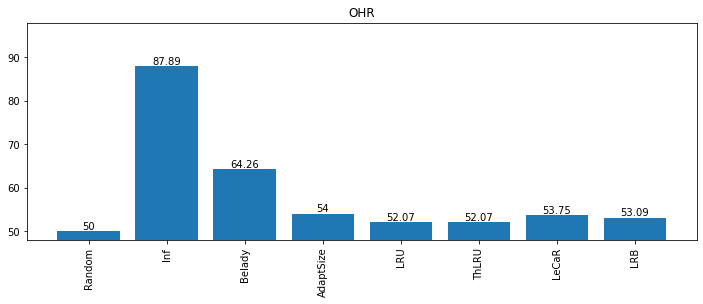

400000000


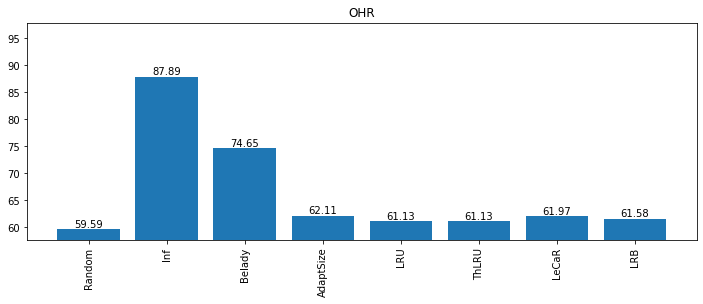

700000000


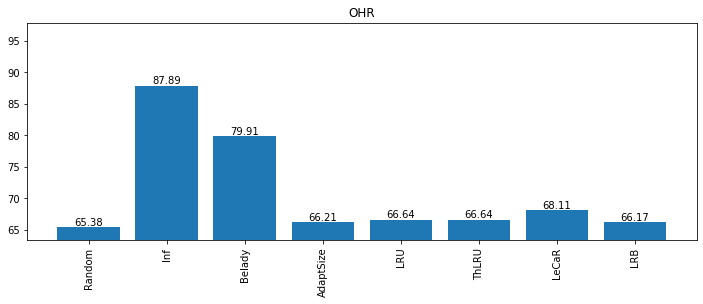

1000000000


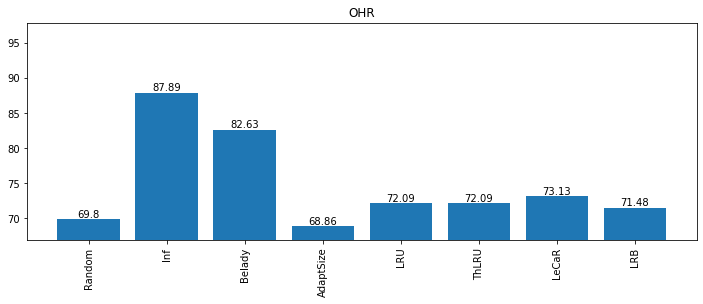

1300000000


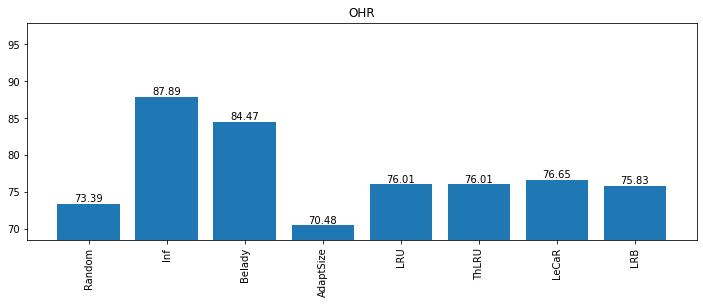

1600000000


1900000000


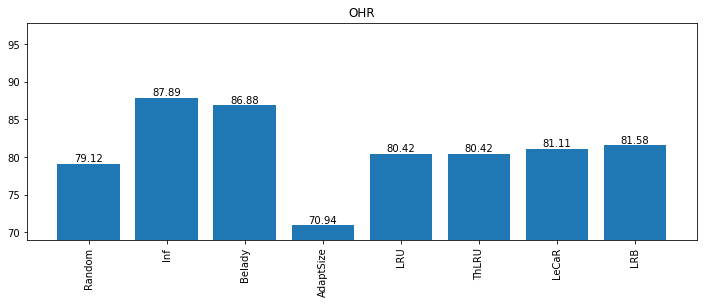

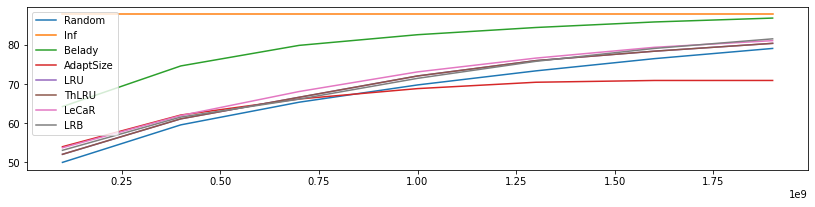

Host 12
response OHR:  23.373238616513333  BHR:  22.8856633050366 #requests 858700
100000000


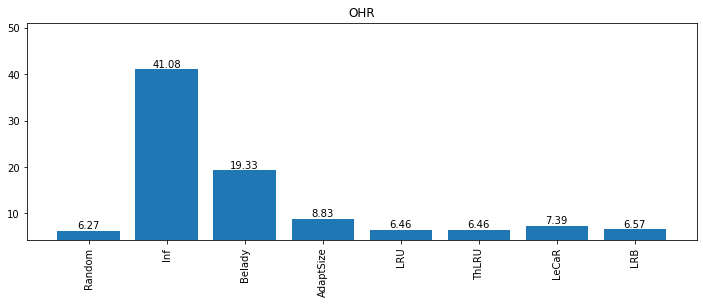

400000000


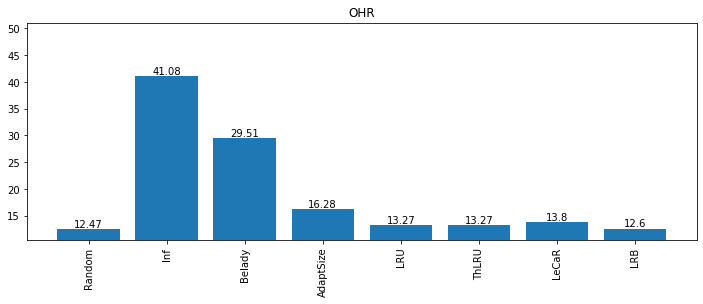

700000000


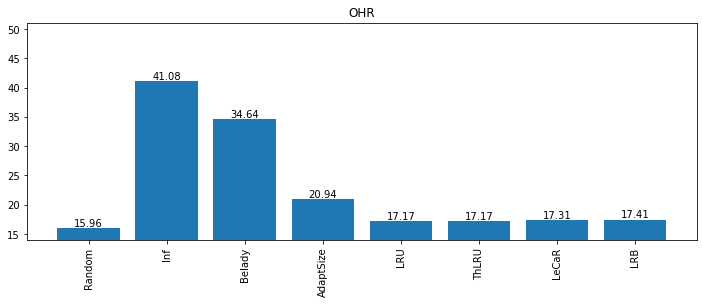

1000000000


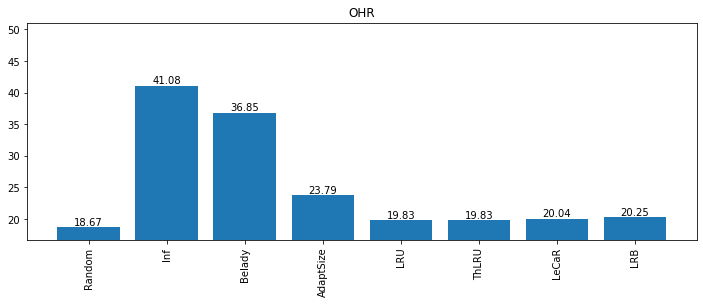

1300000000


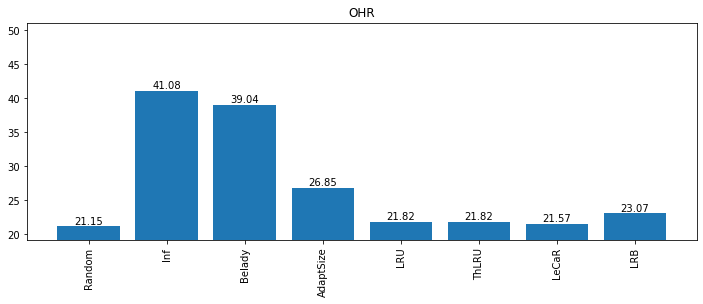

1600000000


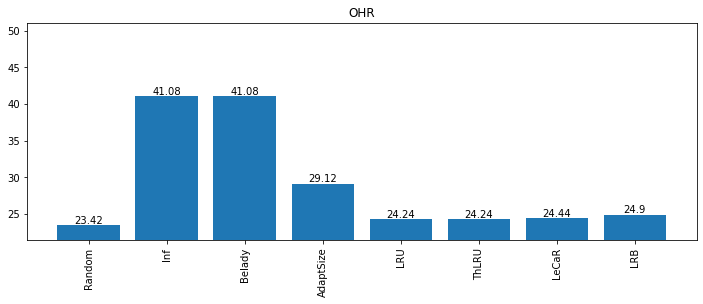

1900000000


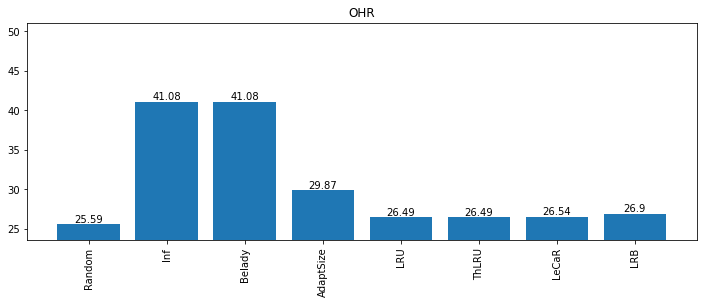

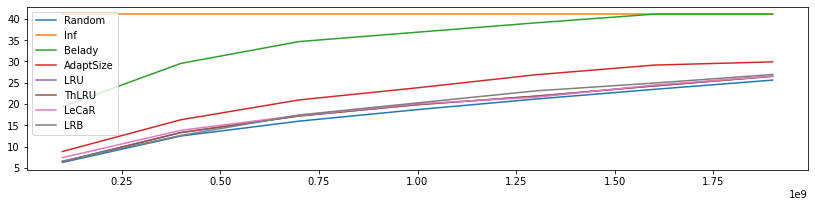

In [52]:
sizes= range(int(1e8),int(2e9),int(3e8))
algos= ["Random","Inf","Belady","AdaptSize","LRU","ThLRU","LeCaR","LRB"]
for key in ['4','12']:
    print("Host", key)
    OHRD={}
    for item in algos:
        OHRD[item]=[]
    get_HR(dfDict[key])
    for size in sizes: 
        print(size)
        f = open('../Results/M2host'+ str(key)+ "-" + str(size)+ '.json')
        data = json.load(f)
        OHR={}
        BHR={}
        for item in data:
            if item['cache_type']!="RelaxedBelady" and item['cache_type']!="UCB":
                OHR[item['cache_type']], BHR[item['cache_type']]=   getHitRatesAlgo(item)
                OHRD[item['cache_type']].append(OHR[item['cache_type']])
        pltDict(OHR, "OHR")
        #pltDict(BHR, "BHR")
    figure(figsize=(14,3))
    for keyp in OHRD:
        plt.plot(sizes, OHRD[keyp])
    plt.legend(algos)
    plt.show()